In [1]:
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

# 데이터셋과 데이터로더 구현
## 경로 리스트 작성

In [2]:
def make_datapath_list(rootpath):
    json_path = osp.join(rootpath, "COCO.json")
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this["root"]

    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]["isValidation"] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]["img_paths"])
        train_img_list.append(img_path)
    
    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]["img_paths"])
        val_img_list.append(img_path)

    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_train2014_"+img_idx+".jpg"
        train_mask_list.append(anno_path)
    
    for idx in val_indexes:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_"+img_idx+".jpg"
        val_mask_list.append(anno_path)

    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath="./data/")

In [3]:
val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

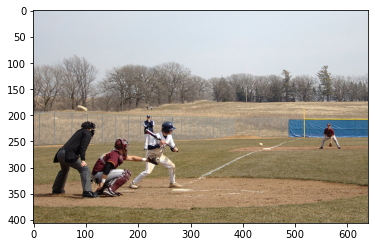

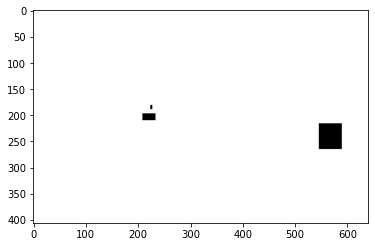

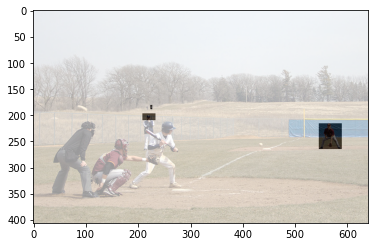

In [4]:
index = 24

img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6,0)
plt.imshow(blend_img)
plt.show()

## 화상 전처리 작성

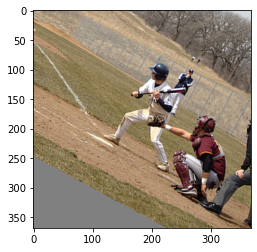

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


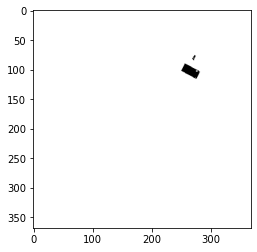

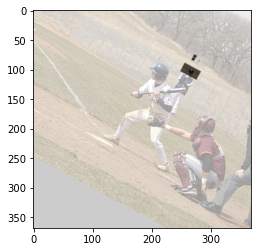

In [5]:
from utils.data_augumentation import *

class DataTransform():
    def __init__(self):
        self.data_transform = {
            "train":Compose([
                get_anno(),
                add_neck(),
                aug_scale(),
                aug_rotate(),
                aug_croppad(),
                aug_flip(),
                remove_illegal_joint(),
                no_Normalize_Tensor()
            ]),
            "val" : Compose([

            ])
        }
    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)

        return meta_data, img, mask_miss

index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1,2,0))
plt.imshow(img)
plt.show()

mask_miss = mask_miss.numpy().transpose((1,2,0))
plt.imshow(mask_miss)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert("RGB"))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert("RGB"))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

## 어노테이션 데이터 작성


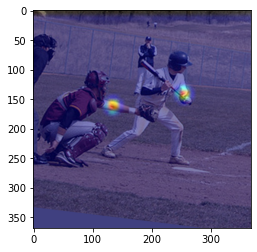

In [7]:
from utils.dataloader import get_ground_truth

index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1,2,0))
mask_miss = mask_miss.numpy().transpose((1,2,0))

heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

img = Image.fromarray(np.uint8(img * 255))
img = np.asarray(img.convert("RGB"))

# 왼쪽 팔꿈치
heat_map = heatmaps[:,:,6]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)* 255))
heat_map = np.asarray(heat_map.convert("RGB"))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC
)

blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

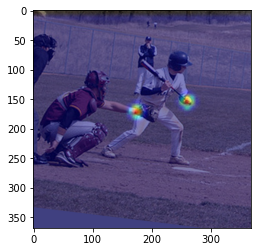

In [8]:
# 왼쪽 손목
heat_map = heatmaps[:,:,7]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)* 255))
heat_map = np.asarray(heat_map.convert("RGB"))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC
)

blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

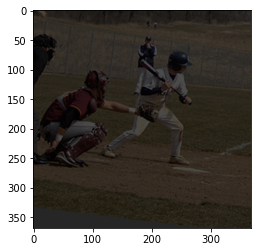

In [9]:
# 왼쪽 팔꿈치와 왼쪽 손목에 PAF 확인
paf = pafs[:,:,24]
paf = Image.fromarray(np.uint8(paf) * 255)
paf = np.asarray(paf.convert("RGB"))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC
)

blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()

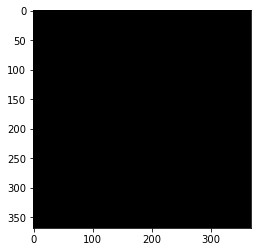

In [10]:
# PAF 만 표시
paf = pafs[:,:,24]
paf = Image.fromarray(np.uint8(paf) * 255)
paf = np.asarray(paf.convert("RGB"))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC
)

plt.imshow(paf)


## 데이터셋 작성

In [14]:
class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCO Cocokeypoints의 Dataset를 작성하는 클래스. PyTorch Dataset 클래스를 상속.

    Attributes
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정.
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''화상의 Tensor 형식 데이터, 어노테이션, 마스크를 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]

        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 화상 전처리
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 정답 어노테이션 데이터 취득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. 마스크 데이터는 RGB가 (1,1,1) 또는 (0,0,0)이므로, 차원을 낮춘다
        # 마스크된 위치는 값이 0, 그렇지 않으면 1입니다
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. 채널이 맨 끝에 있으므로, 순서를 변경
        # 예: paf_mask: torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# 데이터 꺼내기 예
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


## 데이터 로더 작성

In [15]:
batch_size = 8

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
item = next(batch_iterator)
print(item[0].shape)
print(item[1].shape)
print(item[2].shape)
print(item[3].shape)
print(item[4].shape)

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])
